# Logistic Regression on the Titanic Dataset

Welcome! This lecture-style notebook walks through a full classification workflow using logistic regression on the Titanic dataset.

We will cover:
- Problem framing and dataset overview
- Exploratory data analysis (EDA)
- Data cleaning and feature engineering
- Train/test split and baseline model
- Feature selection (RFE)
- Model evaluation: accuracy, classification report, cross-validation
- Decision thresholds, ROC curve, and confusion matrices

By the end, you should understand the end-to-end steps and the reasoning behind each one.


## Setup and Imports

We import core scientific Python libraries, visualization tools, and scikit-learn components we'll need for modeling.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
)
from sklearn.feature_selection import RFE

# Plotting defaults for visibility
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 150


## Load the Titanic Dataset

We will use Seaborn's built-in `titanic` dataset. The target variable is `survived` (1 if survived, 0 if not).


In [2]:
titanic = sns.load_dataset('titanic')
print(titanic.shape)
titanic.head()


(891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Quick Data Overview

Check column types and missingness to guide cleaning steps.


In [3]:
titanic.info()

titanic.isnull().sum().sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


deck           688
age            177
embarked         2
embark_town      2
sex              0
pclass           0
survived         0
fare             0
parch            0
sibsp            0
class            0
adult_male       0
who              0
alive            0
alone            0
dtype: int64

## Visualizing Missing Values

Visual inspection helps us decide imputation strategies.


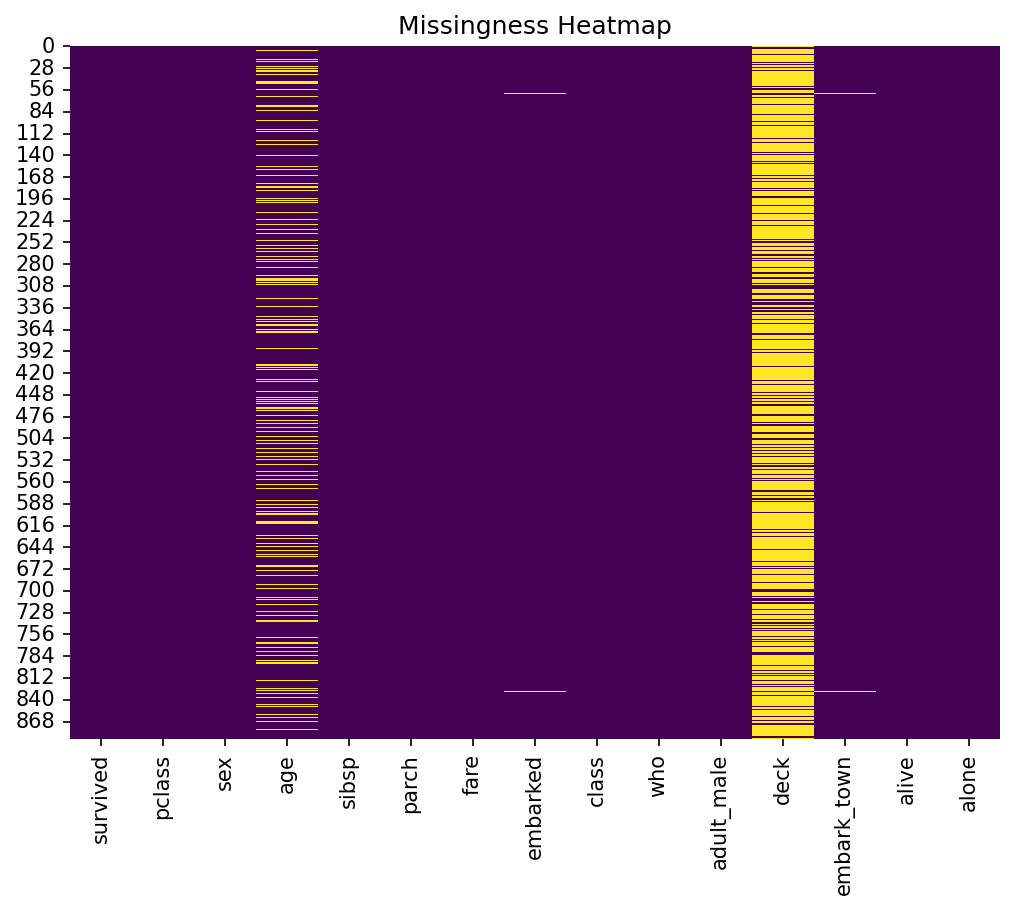

In [4]:
sns.heatmap(titanic.isnull(), cbar=False, cmap='viridis')
plt.title('Missingness Heatmap')
plt.show()


## Age Distribution and KDE

Age has missing values. We examine its distribution overall and by sex/survival to inform imputation.


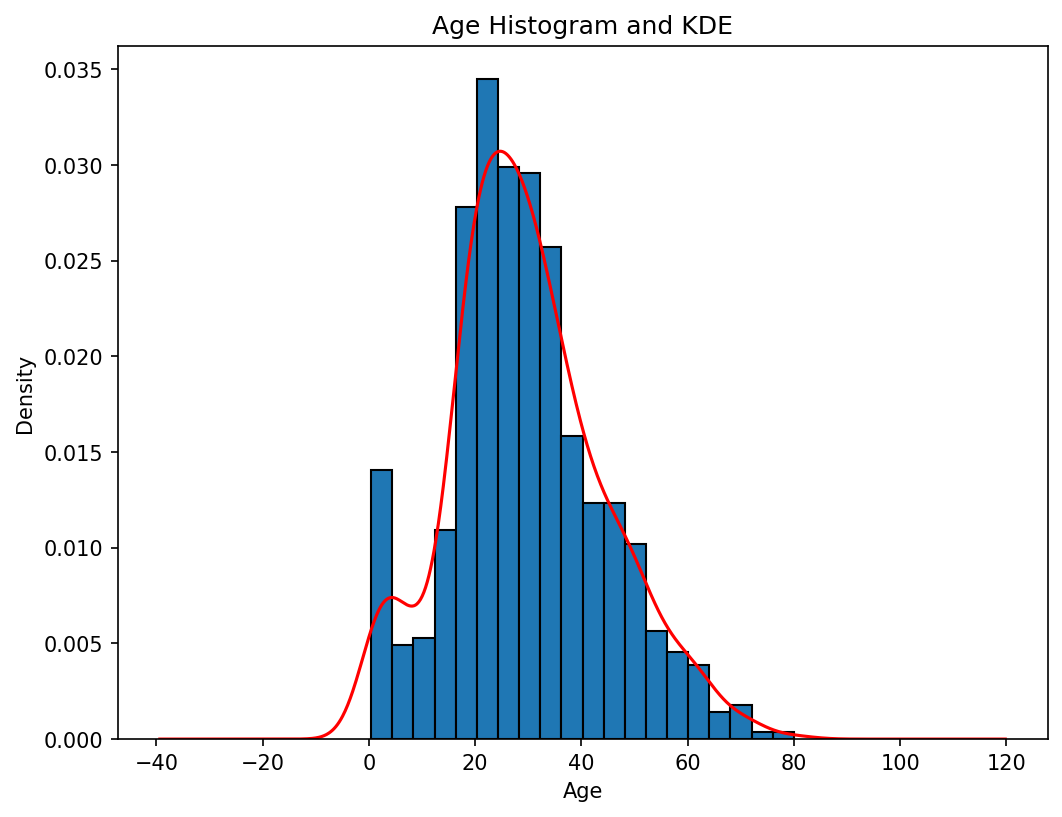

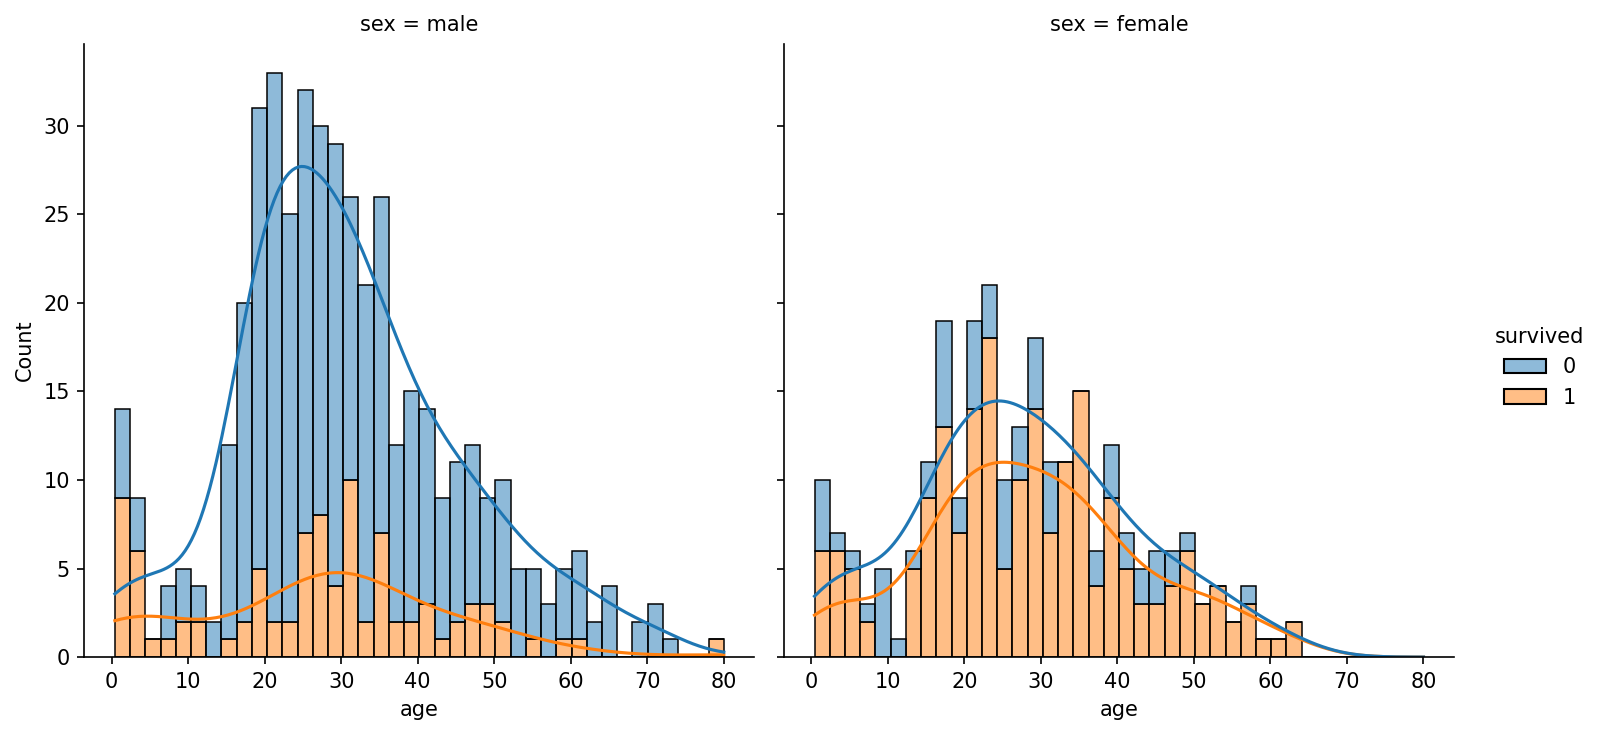

In [5]:
ax = titanic['age'].plot(kind='hist', bins=20, edgecolor='black', density=True)
titanic['age'].plot(kind='density', ax=ax, color='red')
ax.set_xlabel('Age')
ax.set_title('Age Histogram and KDE')
plt.show()

sns.displot(
    data=titanic, x='age', kde=True, bins=40, edgecolor='black', color='blue',
    hue='survived', multiple='stack', col='sex'
)


## Sex and Survival

Survival is strongly related to sex in this dataset. We compute survival rates for men and women.


In [6]:
sex_counts = titanic['sex'].value_counts()
survived_by_sex = titanic[titanic['survived'] == 1]['sex'].value_counts()

men_survival_rate = survived_by_sex.get('male', 0) / sex_counts.get('male', 1)
women_survival_rate = survived_by_sex.get('female', 0) / sex_counts.get('female', 1)

print(f"Men survival rate: {men_survival_rate:.0%}")
print(f"Women survival rate: {women_survival_rate:.0%}")


Men survival rate: 19%
Women survival rate: 74%


## Imputing Missing Age by Class and Sex

We will impute missing `age` using mean age stratified by `pclass` and `sex`. This is a simple and reasonable approach for this dataset.


In [7]:
# Compute group means once for efficiency
age_means = titanic.groupby(['pclass', 'sex'])['age'].mean()

def impute_age(row):
    if pd.isna(row['age']):
        return age_means.loc[(row['pclass'], row['sex'])]
    return row['age']

titanic['age'] = titanic.apply(impute_age, axis=1)

# Validate missingness resolved for age
print('Missing age after imputation:', titanic['age'].isna().sum())


Missing age after imputation: 0


## Handling `embarked` and Dropping High-Null Columns

- Fill `embarked`/`embark_town` missing values using the most common port.
- Drop `deck` due to high missingness.
- Remove derived duplicates where appropriate (e.g., `alive`).


In [8]:
# Fill embarked fields with mode
for col in ['embarked', 'embark_town']:
    if col in titanic.columns:
        mode_val = titanic[col].mode(dropna=True)[0]
        titanic[col] = titanic[col].fillna(mode_val)

# Drop high-null or redundant columns if present
cols_to_drop = [c for c in ['deck', 'embark_town', 'alive'] if c in titanic.columns]
titanic = titanic.drop(columns=cols_to_drop)

# Verify no remaining nulls in used columns
titanic.isnull().sum().sort_values(ascending=False).head(10)


survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
class       0
who         0
dtype: int64

## Encoding and Feature Engineering

- Convert boolean columns to integers.
- One-hot encode categorical columns (`embarked`, `who`, `pclass`) with a reference category dropped to avoid multicollinearity.
- Ensure all features are numeric for scikit-learn.


In [9]:
# Binary/boolean to int
for col in ['adult_male', 'alone']:
    if col in titanic.columns and titanic[col].dtype == 'bool':
        titanic[col] = titanic[col].astype(int)

# Map sex to 0/1 for clarity
if titanic['sex'].dtype == 'object':
    titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# One-hot encode selected categoricals
cat_cols = [c for c in ['embarked', 'who', 'pclass', 'class'] if c in titanic.columns]

titanic = pd.get_dummies(titanic, columns=[c for c in cat_cols if c != 'class'], dtype=int)

# If 'class' (categorical duplicate of pclass) remains, drop it
titanic = titanic.drop(columns=[c for c in ['class'] if c in titanic.columns])

# Drop reference categories to prevent perfect collinearity if present
for base_col, ref in [('embarked', 'S'), ('who', 'woman'), ('pclass', '3')]:
    drop_name = f"{base_col}_{ref}"
    if drop_name in titanic.columns:
        titanic = titanic.drop(columns=[drop_name])

# Ensure all numeric types for modeling
titanic = titanic.apply(pd.to_numeric)

titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   sex         891 non-null    int64  
 2   age         891 non-null    float64
 3   sibsp       891 non-null    int64  
 4   parch       891 non-null    int64  
 5   fare        891 non-null    float64
 6   adult_male  891 non-null    int64  
 7   alone       891 non-null    int64  
 8   embarked_C  891 non-null    int64  
 9   embarked_Q  891 non-null    int64  
 10  who_child   891 non-null    int64  
 11  who_man     891 non-null    int64  
 12  pclass_1    891 non-null    int64  
 13  pclass_2    891 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 97.6 KB


## Train/Test Split and Baseline Logistic Regression

We define features and target, split the data, and fit a baseline logistic regression model.


In [10]:
target_col = 'survived'
input_cols = [c for c in titanic.columns if c != target_col]

X = titanic[input_cols]
y = titanic[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train, y_train)

baseline_acc = baseline_model.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_acc:.3f}")


Baseline accuracy: 0.832


## Recursive Feature Elimination (RFE)

We use RFE to explore how performance changes with different numbers of features and identify a compact set that performs well.


In [11]:
def evaluate_rfe(n_features: int):
    model = LogisticRegression(max_iter=1000)
    selector = RFE(model, n_features_to_select=n_features, step=1)
    selector.fit(X_train, y_train)
    selected_columns = X_train.columns[selector.support_]

    model.fit(X_train[selected_columns], y_train)
    score = model.score(X_test[selected_columns], y_test)
    return list(selected_columns), score

results = []
for n in range(1, min(15, X_train.shape[1]) + 1):
    cols, s = evaluate_rfe(n)
    results.append((n, s, cols))
    print(f"n={n:2d}  acc={s:.3f}  selected={cols}")


n= 1  acc=0.782  selected=['who_man']
n= 2  acc=0.782  selected=['who_man', 'pclass_1']
n= 3  acc=0.782  selected=['adult_male', 'who_man', 'pclass_1']
n= 4  acc=0.782  selected=['adult_male', 'who_man', 'pclass_1', 'pclass_2']
n= 5  acc=0.777  selected=['adult_male', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n= 6  acc=0.782  selected=['adult_male', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n= 7  acc=0.832  selected=['sibsp', 'adult_male', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n= 8  acc=0.832  selected=['sibsp', 'adult_male', 'alone', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n= 9  acc=0.832  selected=['sibsp', 'parch', 'adult_male', 'alone', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n=10  acc=0.827  selected=['sex', 'sibsp', 'parch', 'adult_male', 'alone', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
n=11  acc=0.827  selected=['sex', 'age', 'sibsp', 'parch', 'adult_male', '

## Train Final Model on Selected Features

Pick a strong subset from RFE results and train/evaluate using accuracy, classification report, and cross-validation.


In [13]:
# Select feature set with highest accuracy
best_n, best_acc, best_cols = max(results, key=lambda t: t[1])
print(f"Best RFE: n={best_n}, acc={best_acc:.3f}\nFeatures: {best_cols}")

final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train[best_cols], y_train)

y_pred = final_model.predict(X_test[best_cols])
print(f"Test accuracy (selected features): {accuracy_score(y_test, y_pred):.3f}")

print(classification_report(y_test, y_pred))


Best RFE: n=7, acc=0.832
Features: ['sibsp', 'adult_male', 'embarked_C', 'embarked_Q', 'who_man', 'pclass_1', 'pclass_2']
Test accuracy (selected features): 0.832
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       110
           1       0.82      0.72      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



## Cross-Validation and Confusion Matrix

We validate stability with k-fold cross-validation and visualize errors using a confusion matrix.


CV mean accuracy: 0.812 ± 0.019


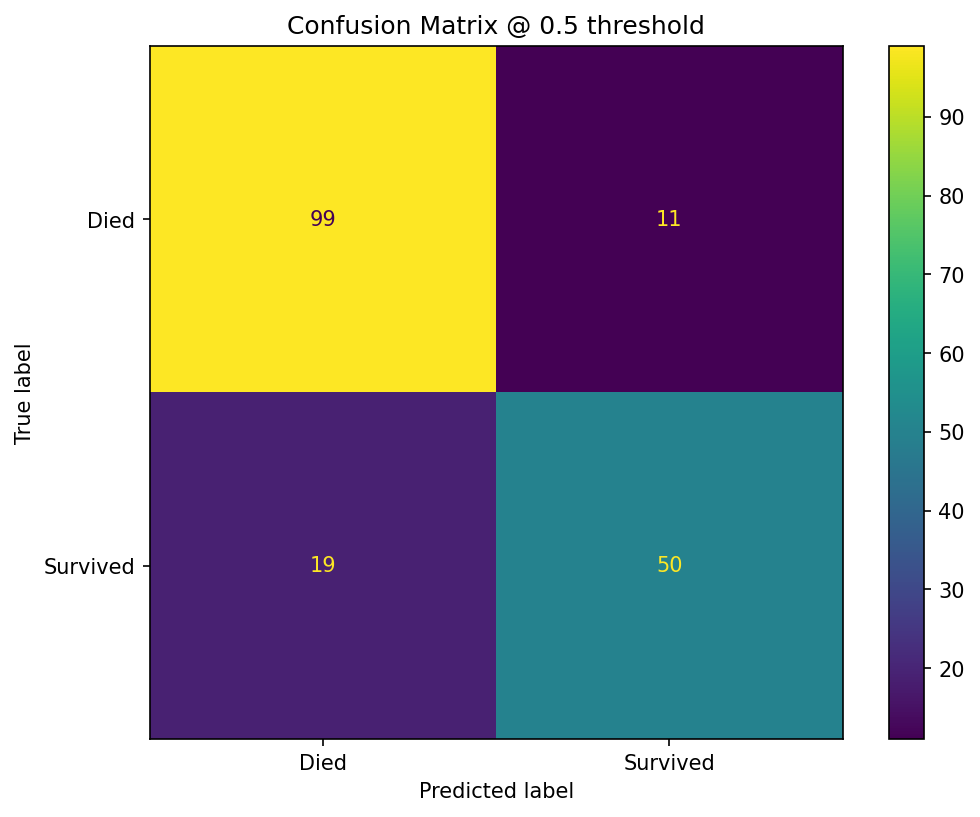

In [14]:
cv_scores = cross_val_score(final_model, X_train[best_cols], y_train, cv=5)
print(f"CV mean accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Died', 'Survived'])
disp.plot()
plt.title('Confusion Matrix @ 0.5 threshold')
plt.show()


## ROC Curve and Decision Thresholds

Logistic regression outputs probabilities. The default decision threshold is 0.5, but changing it trades off false positives and false negatives. We plot the ROC curve and select an operating point.


Chosen threshold: 0.530, FPR=0.100, TPR=0.725


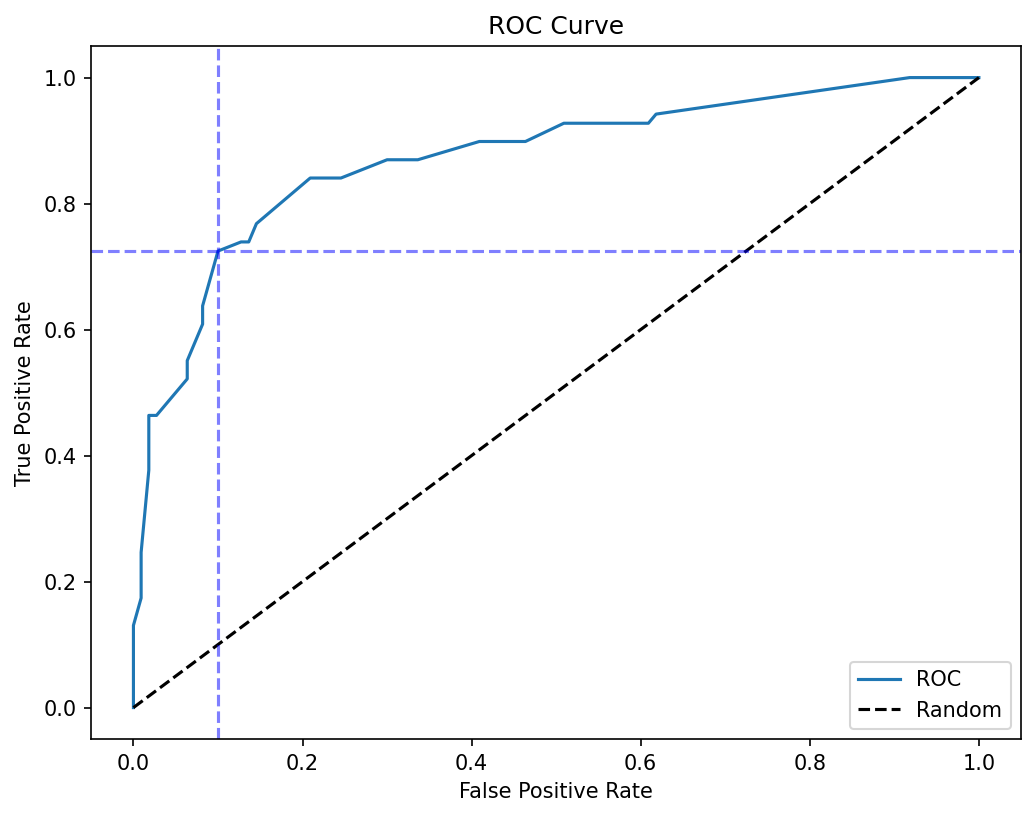

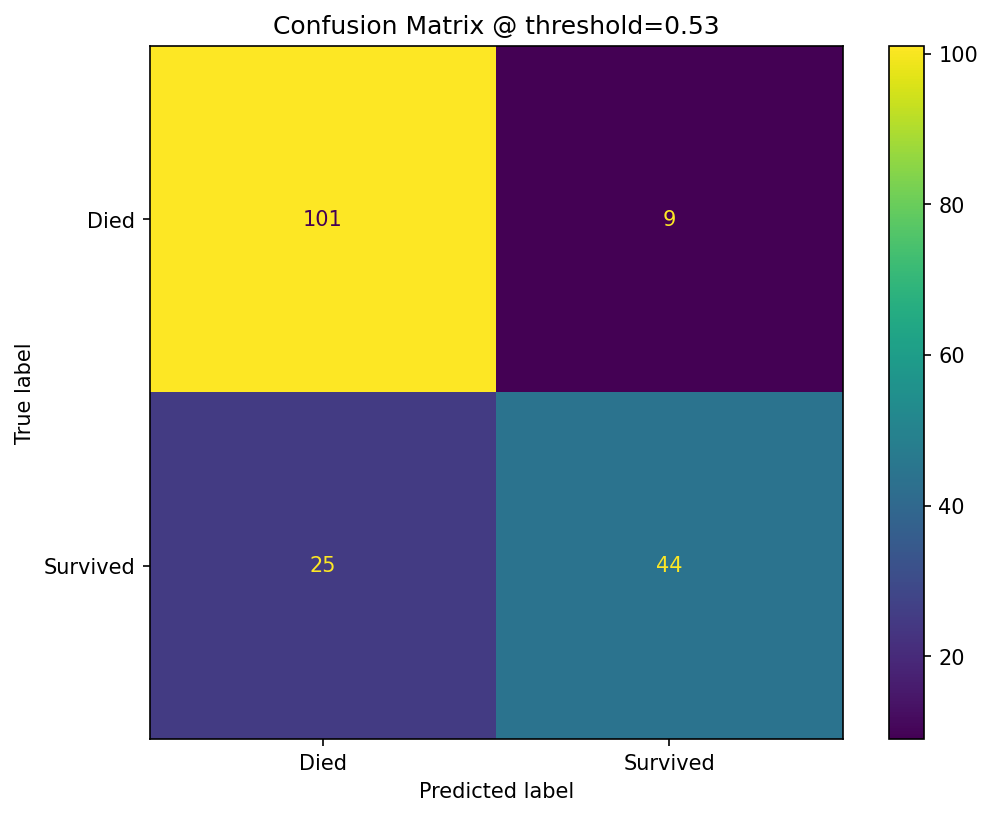

In [15]:
y_proba = final_model.predict_proba(X_test[best_cols])[:, 1]

fpr, tpr, thr = roc_curve(y_test, y_proba)

# Example: choose threshold near FPR < 0.10 (application-dependent)
idx = (fpr < 0.10).sum()  # first index where FPR >= 0.10
idx = min(idx, len(thr) - 1)
chosen_thr = thr[idx]
print(f"Chosen threshold: {chosen_thr:.3f}, FPR={fpr[idx]:.3f}, TPR={tpr[idx]:.3f}")

plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.axvline(fpr[idx], color='b', linestyle='--', alpha=0.5)
plt.axhline(tpr[idx], color='b', linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Evaluate at chosen threshold
y_pred_thr = (y_proba > chosen_thr).astype(int)
cm_thr = confusion_matrix(y_test, y_pred_thr)
ConfusionMatrixDisplay(cm_thr, display_labels=['Died', 'Survived']).plot()
plt.title(f'Confusion Matrix @ threshold={chosen_thr:.2f}')
plt.show()
